In [1]:
from netCDF4 import Dataset                     # For reading data
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt                 # For plotting
import numpy.ma as ma
import xarray as xray
from mpas_xray import preprocess_mpas, remove_repeated_time_index

# Place figures within document
%pylab inline
pylab.rcParams['figure.figsize'] = (18.0, 10.0) # Large figures

Populating the interactive namespace from numpy and matplotlib


In [28]:
#Load Data
ds = xray.open_mfdataset('/net/scratch1/lvanroekel/newMesh_w_topo/output/KPP_test.001[3-6]-*-01_00.00.00.nc',\
                          preprocess=preprocess_mpas)
ds = remove_repeated_time_index(ds)

# perform time average
dsm=ds.mean(dim="Time")

In [29]:
nCells = dsm.dims['nCells'];
nVertices = dsm.dims['nVertices'];
nEdges = dsm.dims['nEdges'];
nVertLevels = dsm.dims['nVertLevels'];

#set number of bins in longitude and latitude
nBinsLongitude = 100
nBinsLatitude = 40

rtd = 180.0/pi

latCell = dsm.latCell.values;
latCellMax = np.amax(latCell)
latCellMin = np.amin(latCell)

lonCell = dsm.lonCell.values;
indVals = np.where(lonCell > np.pi)
lonCell[indVals] -= np.pi*2.0
lonCellMax = 0 #np.amax(lonCell)
lonCellMin = 2*np.pi #np.amin(lonCell)

In [30]:
from scipy.spatial import cKDTree

def lon_lat_to_cartesian(lon, lat, R = 6371229):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x,y,z

def init_tree(lon_w, lon_e, lat_s, lat_n, nLat, nLon):
    
    xs, ys, zs = lon_lat_to_cartesian(lonCell*rtd,latCell*rtd)
    tree = cKDTree(zip(xs, ys, zs))
    
    lonT = np.linspace(lon_w,lon_e,nLon)
    latT = np.linspace(lat_s,lat_n,nLat)

    lonTarg, latTarg = np.meshgrid(lonT, latT)
    xt, yt, zt = lon_lat_to_cartesian(lonTarg.flatten(),latTarg.flatten())
    
    d, inds = tree.query(zip(xt, yt, zt), k = 1)
    
    return d, inds, lonTarg, latTarg

def interp_fields(field, d, inds):
    #d, inds = tree.query(zip(xt, yt, zt), k = 10)
    #w = 1.0 / d**2
    #interpFld = np.sum(w * temp.flatten()[inds],axis=1) / np.sum(w, axis=1)
    #interpFld.shape = lonTarg.shape
    
    return field.flatten()[inds].reshape(lonTarg.shape)

In [31]:
botDepth = dsm.bottomDepth.values
zmid = dsm.zMid.values
temp = dsm.temperature.values
zon = dsm.velocityZonal.values
mer = dsm.velocityMeridional.values
ke = 0.5*(zon*zon + mer*mer)

nLon = 360
nLat = 100
lon_w = 0
lon_e = 360
lat_s = -70
lat_n = -53

outTemp = np.zeros((nLat,nLon,nVertLevels))
outU = np.zeros((nLat,nLon,nVertLevels))
outV = np.zeros((nLat,nLon,nVertLevels))
outKE = np.zeros((nLat,nLon,nVertLevels))
botInterp = np.zeros((nLat,nLon))
zInterp = np.zeros((nLat,nLon,nVertLevels))

d, inds, lonTarg, latTarg = init_tree(lon_w, lon_e, lat_s, lat_n, nLat, nLon)
botInterp = interp_fields(botDepth, d, inds)

for k in range(nVertLevels):
    inds2 = np.where(dsm.maxLevelCell.values-1 < k)[0]

    temp[inds2,k] = NaN
    outTemp[:,:,k] = interp_fields(temp[:,k], d, inds)
    
    zon[inds2,k] = NaN
    outU[:,:,k] = interp_fields(zon[:,k], d, inds)
    
    mer[inds2,k] = NaN
    outV[:,:,k] = interp_fields(mer[:,k], d, inds)
    
    ke[inds2,k] = NaN
    outKE[:,:,k] = interp_fields(ke[:,k], d, inds)
    
    zmid[inds2,k] = NaN
    zInterp[:,:,k] = interp_fields(zmid[:,k], d, inds)

In [32]:
lonTarg.max()

360.0

In [33]:
outTemp.shape

(100, 360, 100)

In [34]:
#create vertical and horizontal cross sections 

zonal_avg = True
#If not zonal average, specify a longitude.
lon_slice = 0

lonmin = 50
lonmax = 120

if zonal_avg:
    i1 = abs(lonTarg[0,:] - lonmin).argmin()
    i2 = abs(lonTarg[0,:] - lonmax).argmin()
    
    tempAvg = outTemp[:,i1:i2+1,:].mean(axis=1)
    uAvg = outU[:,i1:i2+1,:].mean(axis=1)
    vAvg = outV[:,i1:i2+1,:].mean(axis=1)
    keAvg = outKE[:,i1:i2+1,:].mean(axis=1)
    zAvg = zInterp[:,i1:i2+1,:].mean(axis=1)
else:
    spot = (lon[0,:] - lon_slice).argmin()
    tempAvg = np.squeeze(outTemp[:,spot,:])
    uAvg = np.squeeze(outU[:,spot,:])
    vAvg = np.squeeze(outV[:,spot,:])
    keAvg = np.squeeze(outKE[:,spot,:])
    zAvg = np.squeeze(zInterp[:,spot,:])

# create yz mask

mask = np.ones((nLat,nVertLevels))
for i in range(nLat):
    zdiff = abs(zAvg[i,:nVertLevels-1]-zAvg[i,1:nVertLevels])
    indVals = np.where(zdiff < 1E-2)[0] 
    mask[i,indVals] = np.nan
    mask[i,nVertLevels-1] = np.nan
        
latyz = np.zeros((nLat,nVertLevels))
for i in range(nVertLevels):
    latyz[:,i] = latTarg[:,0]

(-3500, 0)

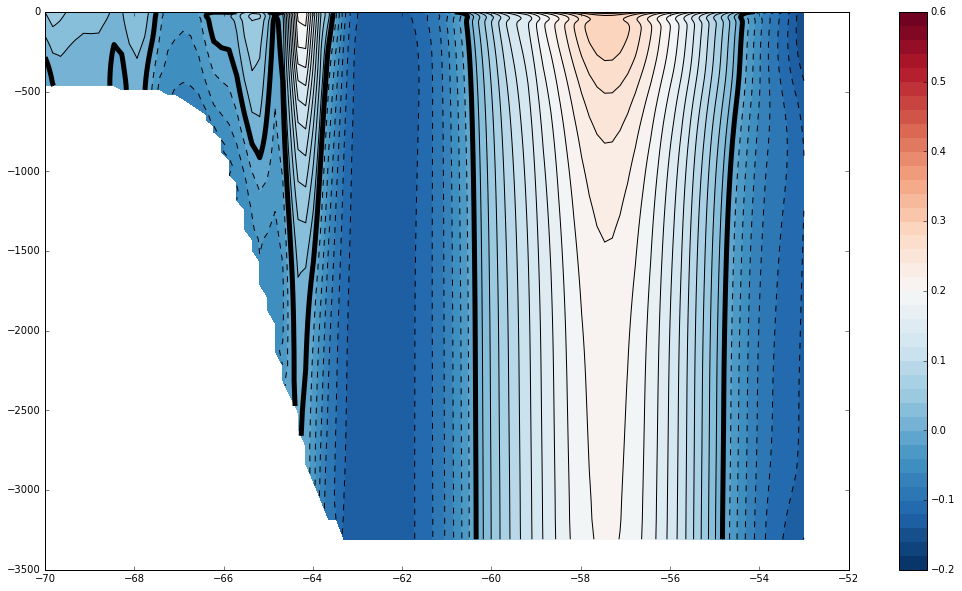

In [35]:
#vertical U cross-sections
plt.contourf(latyz, zAvg, uAvg , levels = np.linspace(-0.2,0.6,41),cmap='RdBu_r')
plt.colorbar()
#contours
plt.contour(latyz,zAvg, uAvg , levels = np.linspace(-0.2,0.6,41), colors='k')
#contour zero line special
plt.contour(latyz,zAvg, uAvg , levels = [0], colors='k',linewidths=5)
plt.xlim(-70,-52)
plt.ylim(-3500,0)

(-3500, 0)

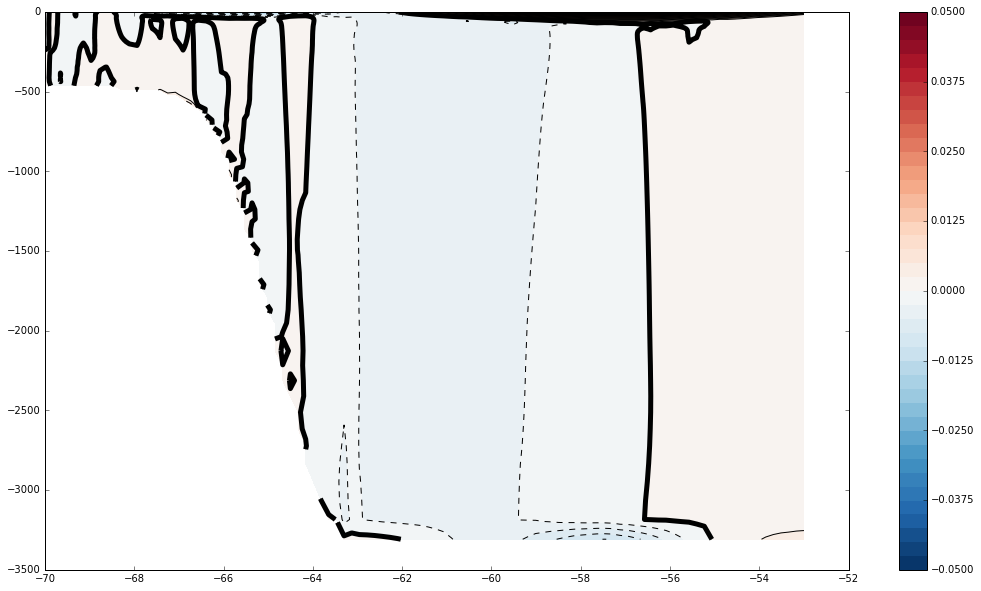

In [36]:
#vertical V cross-sections
plt.contourf(latyz, zAvg, vAvg , levels = np.linspace(-0.05,0.05,41),cmap='RdBu_r')
plt.colorbar()
#contours
plt.contour(latyz,zAvg, vAvg , levels = np.linspace(-0.05,0.05,41), colors='k')
#contour zero line special
plt.contour(latyz,zAvg, vAvg , levels = [0], colors='k',linewidths=5)
plt.xlim(-70,-52)
plt.ylim(-3500,0)

(-3500, 0)

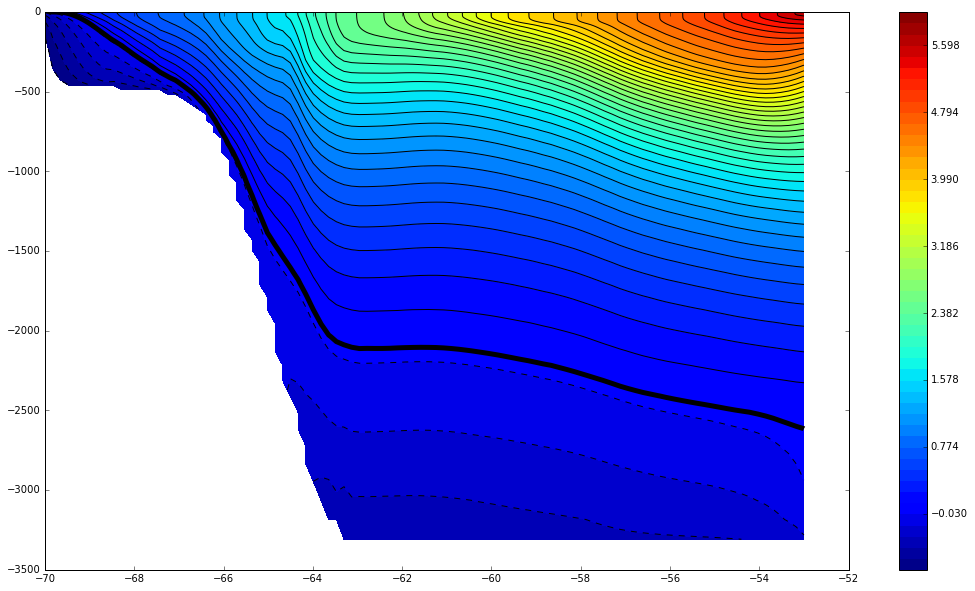

In [37]:
#vertical V cross-sections
plt.contourf(latyz, zAvg, tempAvg , levels = np.linspace(-0.7,6,51))
plt.colorbar()
#contours
plt.contour(latyz,zAvg, tempAvg , levels = np.linspace(-0.7,6,51), colors='k')
#contour zero line special
plt.contour(latyz,zAvg, tempAvg , levels = [0], colors='k',linewidths=5)
plt.xlim(-70,-52)
plt.ylim(-3500,0)

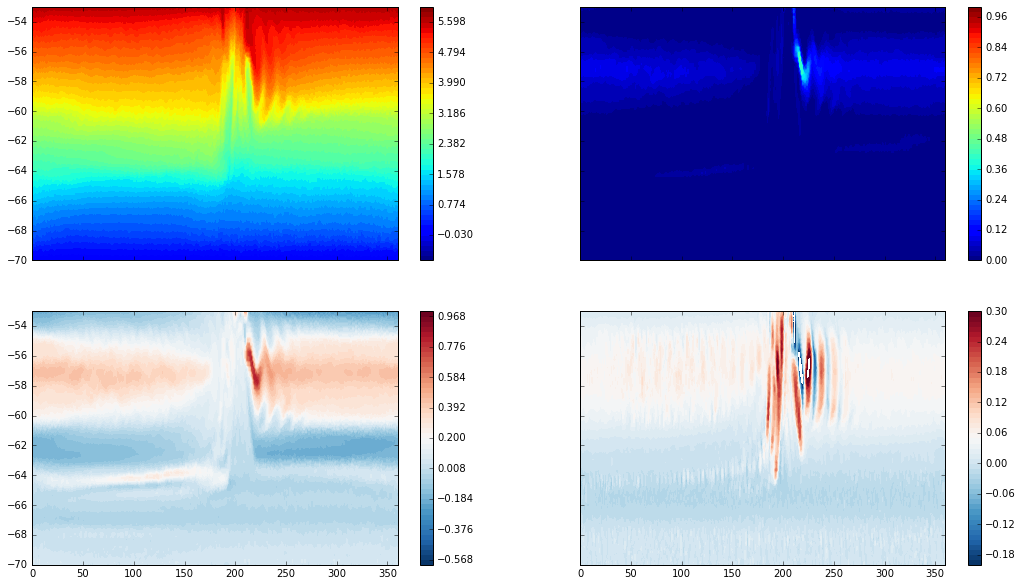

In [16]:
#Surface plots
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex='col',sharey='row')
pc=ax1.contourf(lonTarg,latTarg,outTemp[:,:,0],levels=np.linspace(-0.7,6,51))
fig.colorbar(pc,ax=ax1)
#ax1.set_ylim(-100, 0)
#ax1.set_xlim(1,4)

pc=ax2.contourf(lonTarg,latTarg,outKE[:,:,0],levels=np.linspace(0,1,51))
fig.colorbar(pc,ax=ax2)

pc=ax3.contourf(lonTarg,latTarg,outU[:,:,0],levels=np.linspace(-0.6,1,51),cmap='RdBu_r')
fig.colorbar(pc,ax=ax3)

pc=ax4.contourf(lonTarg,latTarg,outV[:,:,0],levels=np.linspace(-0.2,0.3,51),cmap='RdBu_r')
fig.colorbar(pc,ax=ax4)

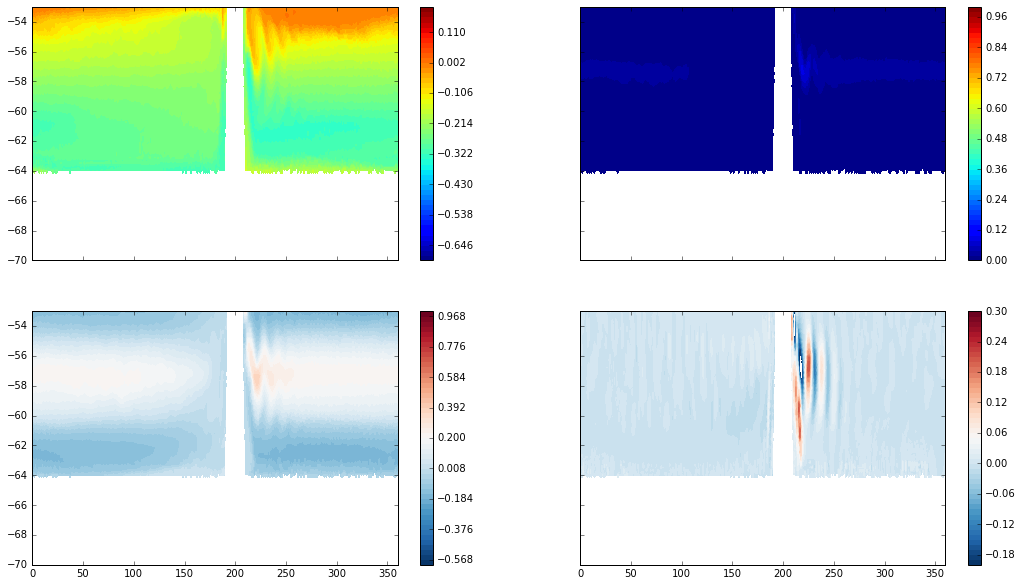

In [17]:
#Bottom layer plots
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex='col',sharey='row')
pc=ax1.contourf(lonTarg,latTarg,outTemp[:,:,95],levels=np.linspace(-0.7,0.2,51))
fig.colorbar(pc,ax=ax1)
#ax1.set_ylim(-100, 0)
#ax1.set_xlim(1,4)

pc=ax2.contourf(lonTarg,latTarg,outKE[:,:,95],levels=np.linspace(0,1,51))
fig.colorbar(pc,ax=ax2)

pc=ax3.contourf(lonTarg,latTarg,outU[:,:,95],levels=np.linspace(-0.6,1,51),cmap='RdBu_r')
fig.colorbar(pc,ax=ax3)

pc=ax4.contourf(lonTarg,latTarg,outV[:,:,95],levels=np.linspace(-0.2,0.3,51),cmap='RdBu_r')
fig.colorbar(pc,ax=ax4)